Purpose: Problem set 3 code

Created: Nico Rotundo 2024-11-20

Import packages and data, and define useful functions

In [438]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from colorama import Fore, Style
import matplotlib.pyplot as plt


# Define ANSI escape codes for the orange color
orange = '\033[38;5;214m'  # Orange color (ANSI code 214)
reset = '\033[0m'          # Reset to default color

## Adjust display options
# Show all columns
pd.set_option('display.max_columns', None)  

# Automatically adjust to screen width
pd.set_option('display.width', 1000)          

# Set maximum column width to 50 (or adjust as needed)
pd.set_option('display.max_colwidth', 50)  

# Load the CSV file into a DataFrame
data = pd.read_csv("/Users/nicorotundo/Library/CloudStorage/Box-Box/econ_240a/data/nlsy97ss.csv")

# Sort by id 
data = data.sort_values(by='pubid', ascending=True)

'''--------------------------------------------------------------------------------------------------------------------------------------
    Mimics Stata's `tab` command for a given column in a DataFrame.
 
    Parameters:
        data (pd.DataFrame): The dataset.
        column (str): The name of the column to tabulate.
    
    Returns:
        pd.DataFrame: A DataFrame with Value, Frequency, Percentage, and Cumulative Percentage.
--------------------------------------------------------------------------------------------------------------------------------------'''

def tabulate_variable(data, column):
    
   # Calculate value counts and normalize for percentages
    value_counts = data[column].value_counts(dropna=False)

    # Directly create a DataFrame
    tab_output = pd.DataFrame({
        'Value': value_counts.index,
        'Frequency': value_counts.values
    })

    # Sort the results by the Value column in ascending order
    tab_output = tab_output.sort_values(by='Value', ascending=True)
    
    # Add percentage column
    tab_output['Percentage'] = (tab_output['Frequency'] / tab_output['Frequency'].sum()) * 100

    # Add cumulative percentage column
    tab_output['Cumulative Percentage'] = tab_output['Percentage'].cumsum()

    # Display the variable name
    print(f"\nTabulation for variable: {column}\n")

    # Print output and suppress index here
    print(tab_output.to_string(index=False))  


Question 1: Construct a sub-sample of non-black, non-hispanic, non-female respondents with positive earnings. Construct the LogEarn variable. Create a table of summary statistics for avg_earn_2014_to_2018, LogEarn, hgc_ever and asvab for this sub-sample

In [439]:
'''--------------------------------------------------------------------------------------------------------------------------------------
Construct sub-sample of those who are, 
    i. non-black
    
    ii. non-hispanic
    
    iii. non-female respondents 
    
    iv. have positive earnings 
--------------------------------------------------------------------------------------------------------------------------------------'''

# Assert black, hispanic, and non-female indicators only take values 0 and 1 

# Check tabulations for black, hispanic, and non-female indicators
for var in ['black', 'hispanic', 'female']:
    
    # Call tab command from above 
    tabulate_variable(data, var)

    # Add a blank line between outputs
    print("\n")  

# Assert that values for black, hispanic, and female are only 0 or 1
for var in ['black', 'hispanic', 'female']:

    # Get unique values in the column
    unique_values = data[var].unique()  
    assert set(unique_values).issubset({0, 1}), f"Column '{var}' contains invalid values: {unique_values}"


# Create a subsample
sub_sample_white_male = data[

    # Non-black respondents (black = 0)
    (data['black'] == 0) &         

    # Non-Hispanic respondents (hispanic = 0)
    (data['hispanic'] == 0) &      

    # Non-female respondents (female = 0)
    (data['female'] == 0) &        

    # Positive earnings
    (data['avg_earn_2014_to_2018'] > 0)         
].copy()

'''--------------------------------------------------------------------------------------------------------------------------------------
Construct a log earnings variable 
--------------------------------------------------------------------------------------------------------------------------------------'''

# Define new variable for log earnings 
sub_sample_white_male['log_earnings'] = np.log(sub_sample_white_male['avg_earn_2014_to_2018'])

'''--------------------------------------------------------------------------------------------------------------------------------------
Create a table of summary statistics for avg_earn_2014_to_2018, LogEarn, hgc_ever and asvab for this sub-sample 
--------------------------------------------------------------------------------------------------------------------------------------'''

# Create a table of summary statistics
summary_stats = sub_sample_white_male[['avg_earn_2014_to_2018', 'log_earnings', 'hgc_ever', 'asvab']].describe().T

# Format the summary statistics table to 4 significant digits
formatted_summary_stats = summary_stats.map(lambda x: f"{x:.5g}")

# Display the summary statistics table
print(orange + f"\nSummary Statistics Table\n" + reset)
print(orange + formatted_summary_stats.to_string() + reset)


Tabulation for variable: black

 Value  Frequency  Percentage  Cumulative Percentage
     0       4530   73.658537              73.658537
     1       1620   26.341463             100.000000



Tabulation for variable: hispanic

 Value  Frequency  Percentage  Cumulative Percentage
     0       4954   80.552846              80.552846
     1       1196   19.447154             100.000000



Tabulation for variable: female

 Value  Frequency  Percentage  Cumulative Percentage
     0       3044   49.495935              49.495935
     1       3106   50.504065             100.000000



Summary Statistics Table

                      count    mean      std     min     25%     50%     75%         max
avg_earn_2014_to_2018  1606   75822    59828  58.453   38395   61895   94180  3.8398e+05
log_earnings           1606  10.929  0.91493  4.0682  10.556  11.033  11.453      12.858
hgc_ever               1606  14.347   3.0111       6      12      14      16          20
asvab                  1606  56

Question 2: Compute the least squares fit of LogEarn onto a constant and hgc_ever. Report the point estimate on the schooling variable as well as its heteroscedastic robust asymptotic standard error (you may use the StatsModels implementation of OLS to do this; later in the course we will construct our own program for these calculations)

In [440]:
# Define dependent variable (LogEarn)
y = sub_sample_white_male['log_earnings']

# Define independent variables (constant, hgc_ever, asvab)
X = sub_sample_white_male[['hgc_ever']] 

# Add constant (intercept) to the model
X = sm.add_constant(X)

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary to review all results
print(ols_model.summary())

# Extract point estimate for hgc_ever
point_estimate = ols_model.params['hgc_ever']

# Extract robust standard errors as a NumPy array
robust_se_array = ols_model.get_robustcov_results(cov_type='HC0').bse

# Use the index of 'hgc_ever' to access its standard error
robust_se = robust_se_array[X.columns.get_loc('hgc_ever')]

# Display results
print("\n")
print(orange + f"Point Estimate for hgc_ever: {point_estimate: .4g}" + reset)
print(orange + f"Heteroscedastic-Robust Standard Error: {robust_se: .4g}" + reset)


                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     183.5
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           1.18e-39
Time:                        13:54:10   Log-Likelihood:                -2048.6
No. Observations:                1606   AIC:                             4101.
Df Residuals:                    1604   BIC:                             4112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5328      0.105     90.482      0.0

Question 3: Compute the least squares fit of LogEarn on a constant, hgc_ever and asvab. Does the estimate coefficient on hgc_ever change?

In [441]:
# Define dependent variable (LogEarn)
y = sub_sample_white_male['log_earnings']

# Define independent variables (constant, hgc_ever, asvab)
X = sub_sample_white_male[['hgc_ever', 'asvab']]  

# Add constant (intercept) to the model
X = sm.add_constant(X)                 

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary to review all results
print(ols_model.summary())

# Extract point estimate for hgc_ever
point_estimate_hgc = ols_model.params['hgc_ever']

# Extract robust standard errors as a NumPy array
robust_se_array = ols_model.get_robustcov_results(cov_type='HC0').bse

# Use the index of 'hgc_ever' to access its standard error
robust_se_hgc = robust_se_array[X.columns.get_loc('hgc_ever')]

# Display results
print("\n")
print(orange + f"Yes, the point Estimate for hgc_ever changes from {point_estimate: .4g} ({robust_se: .4g}) to {point_estimate_hgc: .4g} ({robust_se_hgc: .4g})" + reset)

                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     105.6
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           8.34e-44
Time:                        13:54:10   Log-Likelihood:                -2036.1
No. Observations:                1606   AIC:                             4078.
Df Residuals:                    1603   BIC:                             4094.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6195      0.106     90.743      0.0

Question 4. Estimate the parameters of the following linear regression model by the method of least squares:

$$
\mathbb{E}^*[ \text{LogEarn} \mid X ] = \alpha_0 + \beta_0 \cdot \text{hgc\_ever} + \gamma_0 \cdot \text{hgc\_ever} \cdot (\text{asvab} - 50) + \delta_0 \cdot \text{asvab}
$$

where:

$$
X = (\text{hgc\_ever}, \text{hgc\_ever} \cdot (\text{asvab} - 50), \text{asvab}).
$$

(a) Provide a semi-elasticity interpretation of $ \beta_0 $.

i. $ \beta_0 $ captures the average percent change in earnings associated with a one unit change in years of schooling, at an AFQT score of exactly 50, all else equal, for the given sample. 
    
ii. Here, the point estimate $ \beta_0 = 0.0713 $ suggests that a one year increase in years of schooling is associated with a $7.13\%$ increase in earnings, at an AFQT score of exactly 50, for non-hispanic white male millenials. 

(b) Provide a semi-elasticity interpretation of $ \beta_0 + \gamma_0 (\text{asvab} - 50) $.

i. $ \beta_0 + \gamma_0 (\text{asvab} - 50) $ captures the average percent change in earnings associated with a one unit change in years of schooling, at an AFQT score different from 50. $ \gamma_0 (\text{asvab} - 50)$ captures the change in the effect of years of schooling on earnings corresponding to a \text{asvab} - 50 unit deviation in AFQT score from 50, all else equal, for the given sample. 
    
ii. Here, the point estimates of $ \beta_0 = 0.0713 $ and $ \gamma_0 (\text{asvab} - 50) = 0.0002562 (\text{asvab} - 50) $ suggests that a one year increase in years of schooling is associated with a $7.13\%$ increase in earnings, with the effect increasing an additional .02562pp for every one-unit positive deviation in AFQT score from 50, for non-hispanic white male millenials. 

In [442]:
# Define the independent variables and the dependent variable
X = sub_sample_white_male.copy()

# Add the required interaction term: hgc_ever * (asvab - 50)
X['hgc_ever_interaction'] = X['hgc_ever'] * (X['asvab'] - 50)

# Define the independent variables (hgc_ever, hgc_ever_interaction, asvab)
X = X[['hgc_ever', 'hgc_ever_interaction', 'asvab']]

# Add constant (intercept)
X = sm.add_constant(X)  

# Dependent variable: LogEarn
y = sub_sample_white_male['log_earnings']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary
print(ols_model.summary())

# Extract the coefficients and ses for the interpretation
beta_0 = ols_model.params['hgc_ever']
gamma_0 = ols_model.params['hgc_ever_interaction']
delta_0 = ols_model.params['asvab']
alpha_0 = ols_model.params['const']

# Extract robust standard errors as a NumPy array
robust_se_array = ols_model.get_robustcov_results(cov_type='HC0').bse

# Use the index of 'hgc_ever' to access its standard error
robust_se_beta_0 = robust_se_array[X.columns.get_loc('hgc_ever')]
robust_se_gamma_0 = robust_se_array[X.columns.get_loc('hgc_ever_interaction')]
robust_se_delta_0 = robust_se_array[X.columns.get_loc('asvab')]
robust_se_alpha_0 = robust_se_array[X.columns.get_loc('const')]

# Display results
print("\n")
print(orange + f"Point Estimate for coefficient on hgc_ever (beta_0): {beta_0: .4g} ({robust_se_beta_0: .4g})" + reset)
print(orange + f"Point Estimate for coefficient on hgc ever interated with asvab-50 (gamma_0): {gamma_0: .4g} ({robust_se_gamma_0: .4g})" + reset)
print(orange + f"Point Estimate for coefficient on asvab (delta_0): {delta_0: .4g} ({robust_se_delta_0: .4g})" + reset)
print(orange + f"Point Estimate for coefficient on constant (alpha_0): {alpha_0: .4g} ({robust_se_alpha_0: .4g})" + reset)



                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     70.70
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           6.09e-43
Time:                        13:54:10   Log-Likelihood:                -2035.7
No. Observations:                1606   AIC:                             4079.
Df Residuals:                    1602   BIC:                             4101.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.8137 

Question 5: Construct a plot with the OLS estimate of β0 + γ0 (asvab − 50) on the y-axis and a grid of asvab values on the x-axis.

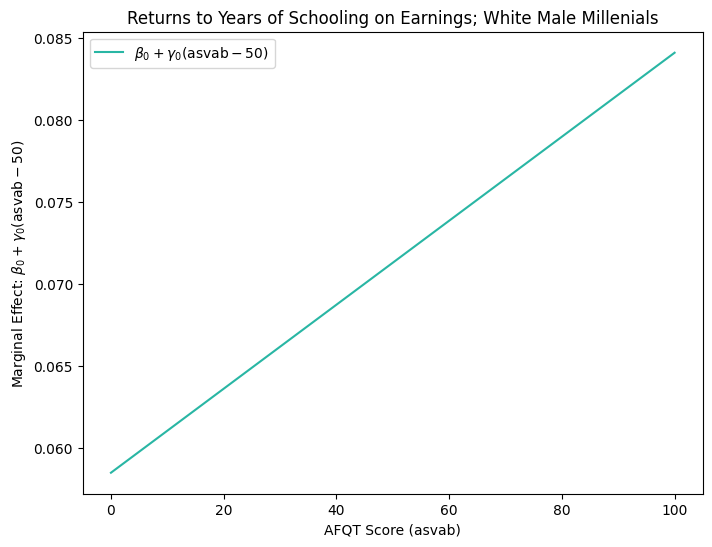

In [443]:
# Generate a grid of asvab values (e.g., from 30 to 80, spanning the range of asvab scores)
asvab_grid = np.linspace(0, 100, 100)

# Compute the OLS estimate of β0 + γ0 (asvab - 50) for each asvab value
marginal_effect = beta_0 + gamma_0 * (asvab_grid - 50)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(asvab_grid, marginal_effect, label=r'$\beta_0 + \gamma_0 (\text{asvab} - 50)$', color=(41/255, 182/255, 164/255))
plt.title('Returns to Years of Schooling on Earnings; White Male Millenials')
plt.xlabel('AFQT Score (asvab)')
plt.ylabel(r'Marginal Effect: $\beta_0 + \gamma_0 (\text{asvab} - 50)$')
plt.legend()
plt.show()

Question 6: Using the Bayes’ Bootstrap to approximate a posterior distribution for $ \beta_0 + \gamma_0 (\text{asvab} − 50) $ at each value of asvab shown in your plot. Add (estimates of) the 0.025 and 0.975 quantiles, as well as the mean, of the posterior distribution of $ \beta_0 + \gamma_0 (\text{asvab} − 50) $ to your plot.

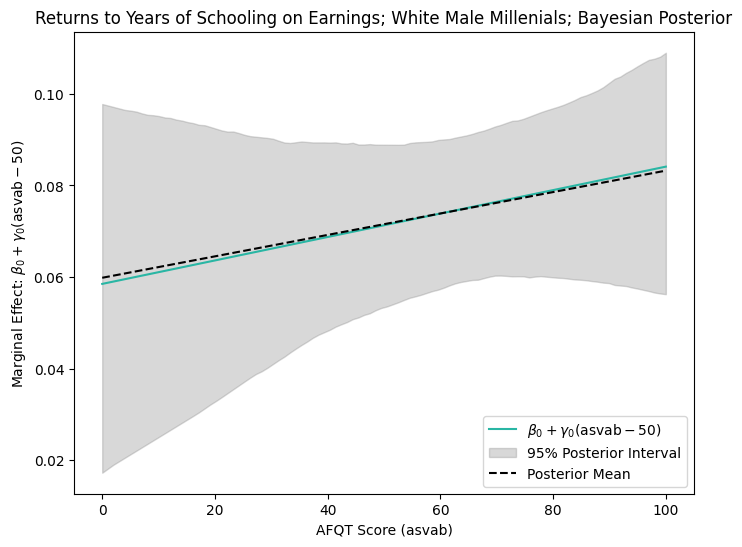

In [444]:
# Number of bootstrap iterations
n_bootstrap = 1000

# Initialize storage for bootstrap estimates
bootstrap_marginal_effects = np.zeros((n_bootstrap, len(asvab_grid)))

# Perform Bayes' Bootstrap
for i in range(n_bootstrap):
    # Generate Dirichlet weights
    dirichlet_weights = np.random.dirichlet(np.ones(len(y)))
    
    # Weighted OLS regression to get new beta_0 and gamma_0
    W = np.sqrt(dirichlet_weights)[:, None]

    # Apply weights to independent variables
    X_weighted = W * X  

    # Apply weights to dependent variable
    y_weighted = W.flatten() * y  
    
    # Fit weighted OLS model
    ols_model_boot = sm.OLS(y_weighted, X_weighted).fit()
    beta_0_boot = ols_model_boot.params['hgc_ever']
    gamma_0_boot = ols_model_boot.params['hgc_ever_interaction']
    
    # Compute marginal effects for current bootstrap sample
    bootstrap_marginal_effects[i, :] = beta_0_boot + gamma_0_boot * (asvab_grid - 50)

# Compute posterior summaries (mean, 2.5th, and 97.5th percentiles)
mean_marginal_effect = np.mean(bootstrap_marginal_effects, axis=0)
lower_bound = np.percentile(bootstrap_marginal_effects, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_marginal_effects, 97.5, axis=0)

# Modify the plot to include posterior summaries
plt.figure(figsize=(8, 6))
plt.plot(asvab_grid, marginal_effect, label=r'$\beta_0 + \gamma_0 (\text{asvab} - 50)$', color=(41/255, 182/255, 164/255))
plt.fill_between(asvab_grid, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Posterior Interval')
plt.plot(asvab_grid, mean_marginal_effect, color='black', linestyle='--', label='Posterior Mean')
plt.title('Returns to Years of Schooling on Earnings; White Male Millenials; Bayesian Posterior')
plt.xlabel('AFQT Score (asvab)')
plt.ylabel(r'Marginal Effect: $\beta_0 + \gamma_0 (\text{asvab} - 50)$')
plt.legend()
plt.show()

Question 7: Summarize what you have learned about the relationship between earnings, schooling and AFQT among white male millennials?

Among non-hispanic white male millenials,
    
i. At baseline, earnings and years of schooling, on average, share a positive relationship whether we control for AFQT scores or not, as seen in the point estimate of hgc_ever in the regressions from questions 2, 3, and 4.

ii. Additionally, there is heterogeneity by AFQT score in the association between years of schooling and earnings. As illustrated in the plot from question 5, the returns to schooling are higher as individual's AFQT scores increase. At the middle value AFQT score (50), a one year increase in years of schooling is associated with a $7.13\%$ increase in earnings, on average. At the lowest AFQT score (0), the predicted effect decreases to slightly below $ 6\% $. At the highest AFQT score (100), the effect increases to around $8.5 \%$

iii. From the visualization corresponding to question 6, we see that the $95\%$ confidence interval is largest at the tails of the AFQT score distribution, and specifically at the lower end of the distribution. However, even at an AFQT score of 50 where the confidence interval is relatively tigher, the effect still ranges from around $4.5 \%$ to as high as around $9 \%$ within the confidence interval

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Question 8: Repeat your analysis for another demographic group of your choice and discuss your findings.

We proceeding with repeating the analysis for non-hispanic black male millenials (with positive earnings).

Among non-hispanic black male millenials,
    
i. At baseline, earnings and years of schooling, on average, share a positive relationship whether we control for AFQT scores or not, as seen in the point estimate of hgc_ever in the regressions from questions 2, 3, and 4. Additionally, the association is stronger for non-hispanic black male millenials than non-hispanic white male millenials.

ii. Additionally, there is heterogeneity by AFQT score in the association between years of schooling and earnings. As illustrated in the plot from question 5, the returns to schooling are lower for non-hispanic black male millenials as individual's AFQT scores increase. At the middle value AFQT score (50), a one year increase in years of schooling is associated with a $11.17\%$ increase in earnings, on average. At the lowest AFQT score (0), the predicted effect increases to slightly below $ 16\% $. At the highest AFQT score (100), the effect decreases to around $ 6\% $. This relationship is opposite of that of non-hispanic white male millenials, which showed returns to schooling increasing as AFQT scores increase.

iii. From the visualization corresponding to question 6, we see that the $95\%$ confidence interval is largest at the tails of the AFQT score distribution, and specifically at the lower end of the distribution. This aspect of the Bayesian plot is similar to that of non-hispanic white male millenials. However, we see the relationship runs in the opposite direction for non-hispanic black male millenials.


Summary Statistics Table

                      count    mean     std      min     25%     50%     75%         max
avg_earn_2014_to_2018   651   44580   40540  0.81538   18241   36781   57002  3.1212e+05
log_earnings            651  10.264  1.1857  -0.2041  9.8114  10.513  10.951      12.651
hgc_ever                651  12.968   2.884        0      11      12      15          20
asvab                   651  28.235  23.232        0  9.1565  22.291  42.639      99.018


                            OLS Regression Results                            
Dep. Variable:           log_earnings   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     133.5
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           3.28e-28
Time:                        13:54:11   Log-Likelihood:                -973.22
No. Observations:                 651   AIC:        

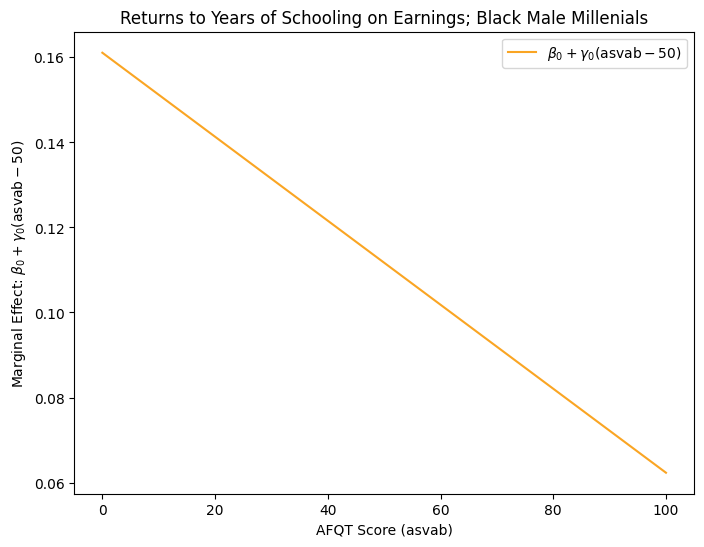

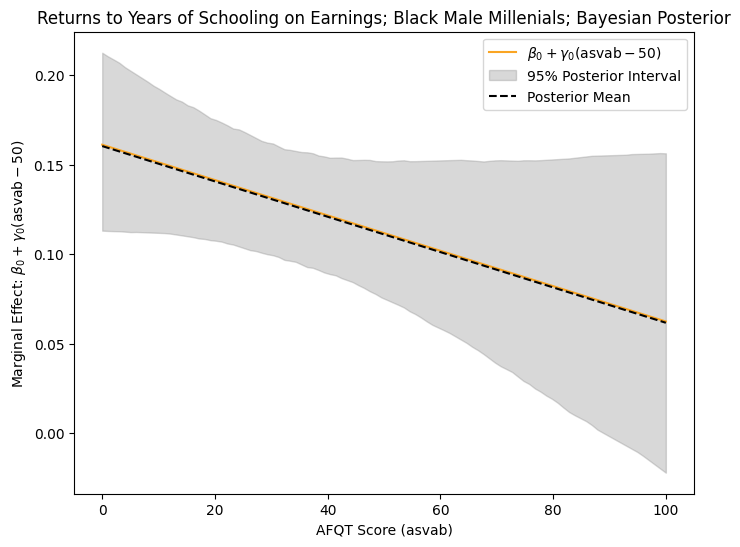

In [445]:
'''--------------------------------------------------------------------------------------------------------------------------------------
Construct sub-sample of those who are, 
    i. black
    
    ii. non-hispanic
    
    iii. non-female respondents 
    
    iv. have positive earnings 
--------------------------------------------------------------------------------------------------------------------------------------'''

# Create a subsample
sub_sample_black_male = data[

    # black respondents (black = 0)
    (data['black'] == 1) &         

    # Non-Hispanic respondents (hispanic = 0)
    (data['hispanic'] == 0) &      

    # Non-female respondents (female = 0)
    (data['female'] == 0) &        

    # Positive earnings
    (data['avg_earn_2014_to_2018'] > 0)         
].copy()

'''--------------------------------------------------------------------------------------------------------------------------------------
Construct a log earnings variable 
--------------------------------------------------------------------------------------------------------------------------------------'''

# Define new variable for log earnings 
sub_sample_black_male['log_earnings'] = np.log(sub_sample_black_male['avg_earn_2014_to_2018'])

'''--------------------------------------------------------------------------------------------------------------------------------------
Question 1: Create a table of summary statistics for avg_earn_2014_to_2018, LogEarn, hgc_ever and asvab for this sub-sample 
--------------------------------------------------------------------------------------------------------------------------------------'''

# Create a table of summary statistics
summary_stats = sub_sample_black_male[['avg_earn_2014_to_2018', 'log_earnings', 'hgc_ever', 'asvab']].describe().T

# Format the summary statistics table to 4 significant digits
formatted_summary_stats = summary_stats.map(lambda x: f"{x:.5g}")

# Display the summary statistics table
print(orange + f"\nSummary Statistics Table\n" + reset)
print(orange + formatted_summary_stats.to_string() + reset)
print("\n")

'''--------------------------------------------------------------------------------------------------------------------------------------
Question 2: Compute the least squares fit of LogEarn onto a constant and hgc_ever. Report the point estimate on the schooling variable as well as its 
heteroscedastic robust asymptotic standard error 
--------------------------------------------------------------------------------------------------------------------------------------'''
# Define dependent variable (LogEarn)
y = sub_sample_black_male['log_earnings']

# Define independent variables (constant, hgc_ever, asvab)
X = sub_sample_black_male[['hgc_ever']] 

# Add constant (intercept) to the model
X = sm.add_constant(X)

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary to review all results
print(ols_model.summary())

# Extract point estimate for hgc_ever
point_estimate = ols_model.params['hgc_ever']

# Extract robust standard errors as a NumPy array
robust_se_array = ols_model.get_robustcov_results(cov_type='HC0').bse

# Use the index of 'hgc_ever' to access its standard error
robust_se = robust_se_array[X.columns.get_loc('hgc_ever')]

# Display results
print("\n")
print(orange + f"Point Estimate for hgc_ever: {point_estimate: .4g}" + reset)
print(orange + f"Heteroscedastic-Robust Standard Error: {robust_se: .4g}" + reset)
print("\n")

'''--------------------------------------------------------------------------------------------------------------------------------------
Question 3: Compute the least squares fit of LogEarn on a constant, hgc_ever and asvab
--------------------------------------------------------------------------------------------------------------------------------------'''
# Define dependent variable (LogEarn)
y = sub_sample_black_male['log_earnings']

# Define independent variables (constant, hgc_ever, asvab)
X = sub_sample_black_male[['hgc_ever', 'asvab']]  

# Add constant (intercept) to the model
X = sm.add_constant(X)                 

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary to review all results
print(ols_model.summary())

# Extract point estimate for hgc_ever
point_estimate_hgc = ols_model.params['hgc_ever']

# Extract robust standard errors as a NumPy array
robust_se_array = ols_model.get_robustcov_results(cov_type='HC0').bse

# Use the index of 'hgc_ever' to access its standard error
robust_se_hgc = robust_se_array[X.columns.get_loc('hgc_ever')]

# Display results
print("\n")
print(orange + f"Yes, the point Estimate for hgc_ever changes from {point_estimate: .4g} ({robust_se: .4g}) to {point_estimate_hgc: .4g} ({robust_se_hgc: .4g})" + reset)
print("\n")

'''--------------------------------------------------------------------------------------------------------------------------------------
Question 4: Estimate the model with the interaction term for hgc_ever and asvab
--------------------------------------------------------------------------------------------------------------------------------------'''
# Define the independent variables and the dependent variable
X = sub_sample_black_male.copy()

# Add the required interaction term: hgc_ever * (asvab - 50)
X['hgc_ever_interaction'] = X['hgc_ever'] * (X['asvab'] - 50)

# Define the independent variables (hgc_ever, hgc_ever_interaction, asvab)
X = X[['hgc_ever', 'hgc_ever_interaction', 'asvab']]

# Add constant (intercept)
X = sm.add_constant(X)  

# Dependent variable: LogEarn
y = sub_sample_black_male['log_earnings']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary
print(ols_model.summary())

# Extract the coefficients and ses for the interpretation
beta_0 = ols_model.params['hgc_ever']
gamma_0 = ols_model.params['hgc_ever_interaction']
delta_0 = ols_model.params['asvab']
alpha_0 = ols_model.params['const']

# Extract robust standard errors as a NumPy array
robust_se_array = ols_model.get_robustcov_results(cov_type='HC0').bse

# Use the index of 'hgc_ever' to access its standard error
robust_se_beta_0 = robust_se_array[X.columns.get_loc('hgc_ever')]
robust_se_gamma_0 = robust_se_array[X.columns.get_loc('hgc_ever_interaction')]
robust_se_delta_0 = robust_se_array[X.columns.get_loc('asvab')]
robust_se_alpha_0 = robust_se_array[X.columns.get_loc('const')]

# Display results
print("\n")
print(orange + f"Point Estimate for coefficient on hgc_ever (beta_0): {beta_0: .4g} ({robust_se_beta_0: .4g})" + reset)
print(orange + f"Point Estimate for coefficient on hgc ever interated with asvab-50 (gamma_0): {gamma_0: .4g} ({robust_se_gamma_0: .4g})" + reset)
print(orange + f"Point Estimate for coefficient on asvab (delta_0): {delta_0: .4g} ({robust_se_delta_0: .4g})" + reset)
print(orange + f"Point Estimate for coefficient on constant (alpha_0): {alpha_0: .4g} ({robust_se_alpha_0: .4g})" + reset)
print("\n")

'''--------------------------------------------------------------------------------------------------------------------------------------
Question 5: Construct a plot with the OLS estimate of β0 + γ0 (asvab − 50) on the y-axis and a grid of asvab values on the x-axis.
--------------------------------------------------------------------------------------------------------------------------------------'''
# Generate a grid of asvab values (e.g., from 30 to 80, spanning the range of asvab scores)
asvab_grid = np.linspace(0, 100, 100)

# Compute the OLS estimate of β0 + γ0 (asvab - 50) for each asvab value
marginal_effect = beta_0 + gamma_0 * (asvab_grid - 50)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(asvab_grid, marginal_effect, label=r'$\beta_0 + \gamma_0 (\text{asvab} - 50)$', color=(250/255, 165/255, 35/255))
plt.title('Returns to Years of Schooling on Earnings; Black Male Millenials')
plt.xlabel('AFQT Score (asvab)')
plt.ylabel(r'Marginal Effect: $\beta_0 + \gamma_0 (\text{asvab} - 50)$')
plt.legend()
plt.show()

'''--------------------------------------------------------------------------------------------------------------------------------------
Question 6: Construct a plot with the OLS estimate of β0 + γ0 (asvab − 50) on the y-axis and a grid of asvab values on the x-axis.
--------------------------------------------------------------------------------------------------------------------------------------'''
# Number of bootstrap iterations
n_bootstrap = 1000

# Initialize storage for bootstrap estimates
bootstrap_marginal_effects = np.zeros((n_bootstrap, len(asvab_grid)))

# Perform Bayes' Bootstrap
for i in range(n_bootstrap):
    # Generate Dirichlet weights
    dirichlet_weights = np.random.dirichlet(np.ones(len(y)))
    
    # Weighted OLS regression to get new beta_0 and gamma_0
    W = np.sqrt(dirichlet_weights)[:, None]

    # Apply weights to independent variables
    X_weighted = W * X  

    # Apply weights to dependent variable
    y_weighted = W.flatten() * y  
    
    # Fit weighted OLS model
    ols_model_boot = sm.OLS(y_weighted, X_weighted).fit()
    beta_0_boot = ols_model_boot.params['hgc_ever']
    gamma_0_boot = ols_model_boot.params['hgc_ever_interaction']
    
    # Compute marginal effects for current bootstrap sample
    bootstrap_marginal_effects[i, :] = beta_0_boot + gamma_0_boot * (asvab_grid - 50)

# Compute posterior summaries (mean, 2.5th, and 97.5th percentiles)
mean_marginal_effect = np.mean(bootstrap_marginal_effects, axis=0)
lower_bound = np.percentile(bootstrap_marginal_effects, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_marginal_effects, 97.5, axis=0)

# Modify the plot to include posterior summaries
plt.figure(figsize=(8, 6))
plt.plot(asvab_grid, marginal_effect, label=r'$\beta_0 + \gamma_0 (\text{asvab} - 50)$', color=(250/255, 165/255, 35/255))
plt.fill_between(asvab_grid, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Posterior Interval')
plt.plot(asvab_grid, mean_marginal_effect, color='black', linestyle='--', label='Posterior Mean')
plt.title('Returns to Years of Schooling on Earnings; Black Male Millenials; Bayesian Posterior')
plt.xlabel('AFQT Score (asvab)')
plt.ylabel(r'Marginal Effect: $\beta_0 + \gamma_0 (\text{asvab} - 50)$')
plt.legend()
plt.show()